## TFT
- need to create feature like date and day of week. 

In [1]:
import xarray as xr
import ocf_blosc2
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.pyplot as plt
# import plotly.express as px
import numpy as np


In [2]:
nwp_data = xr.open_dataset("../../../mnt/disks/gcp_data/nwp/ecmwf/UK_v2.zarr")
nwp_data

<xarray.Dataset> Size: 1TB
Dimensions:    (variable: 14, init_time: 5049, step: 49, latitude: 241,
                longitude: 301)
Coordinates:
  * init_time  (init_time) datetime64[ns] 40kB 2017-01-01 ... 2023-12-31T12:0...
  * latitude   (latitude) float64 2kB 60.0 59.95 59.9 59.85 ... 48.1 48.05 48.0
  * longitude  (longitude) float64 2kB -12.0 -11.95 -11.9 ... 2.9 2.95 3.0
  * step       (step) timedelta64[ns] 392B 00:00:00 01:00:00 ... 2 days 00:00:00
  * variable   (variable) <U5 280B 't2m' 'dswrf' 'dlwrf' ... 'v10' 'u100' 'v100'
Data variables:
    ECMWF_UK   (variable, init_time, step, latitude, longitude) float32 1TB ...

In [3]:
pv_data = xr.open_dataset("data_files/pv.netcdf", engine='h5netcdf')
pv_data

<xarray.Dataset> Size: 2GB
Dimensions:   (datetime: 387254)
Coordinates:
  * datetime  (datetime) datetime64[ns] 3MB 2018-01-01T06:05:00 ... 2021-10-2...
Data variables: (12/1311)
    10003     (datetime) float32 2MB ...
    10004     (datetime) float32 2MB ...
    10005     (datetime) float32 2MB ...
    10048     (datetime) float32 2MB ...
    10049     (datetime) float32 2MB ...
    10063     (datetime) float32 2MB ...
    ...        ...
    9870      (datetime) float32 2MB ...
    9871      (datetime) float32 2MB ...
    9902      (datetime) float32 2MB ...
    9903      (datetime) float32 2MB ...
    9960      (datetime) float32 2MB ...
    9989      (datetime) float32 2MB ...

- For 50 pv_sites, we are selecting 1500 dates. Means 75000
- Then we select 48 hours for each, but not all dates have 48 hours. 
- My dataset is 17046
- It means not all ss_ids, have 1500 datetime, with 48 hours gap. because i am selecting random after 48 hours gap.

Conclusion is that not all points  have all hourly data between 2 days, so it is quite possible if i select a point, it might have only next 5 hours, and not all 48 hours. So dataset would not be optimal 25 ss_ids to 50 datetimes and 48 steps. Multiplication won't work, because there are too many missing data points. 

In [5]:
# add lat, long, tilt orientation
meta_data = pd.read_csv("data_files/metadata.csv")
meta_data.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [6]:
skip_ss_ids = ['8440', '16718', '8715', '17073', '9108', '9172', '10167', '10205', '10207', '10278', '26778', '26819', '10437', '10466', '26915', '10547', '26939', '26971', '10685', '10689', '2638', '2661', '2754', '2777', '2783', '2786', '2793', '2812', '2829', '2830', '2867', '2883', '2904', '2923', '2947', '2976', '2989', '2999', '3003', '3086', '3118', '3123', '3125', '3264', '3266', '3271', '3313', '3334', '3470', '3502', '11769', '11828', '11962', '3772', '11983', '3866', '3869', '4056', '4067', '4116', '4117', '4124', '4323', '4420', '20857', '4754', '13387', '13415', '5755', '5861', '5990', '6026', '6038', '6054', '14455', '6383', '6430', '6440', '6478', '6488', '6541', '6548', '6560', '14786', '6630', '6804', '6849', '6868', '6870', '6878', '6901', '6971', '7055', '7111', '7124', '7132', '7143', '7154', '7155', '7156', '7158', '7201', '7237', '7268', '7289', '7294', '7311', '7329', '7339', '7379', '7392', '7479', '7638', '7695', '7772', '15967', '7890', '16215', '7830']

In [7]:
# def get_48_hour_range(start_datetime):
#     end_datetime = start_datetime + pd.Timedelta(hours=47, minutes=59)
#     return start_datetime, end_datetime

def get_36_hour_range(start_datetime, hours=36):
    end_datetime = start_datetime + pd.Timedelta(hours=hours - 1, minutes=59)
    return start_datetime, end_datetime

def select_non_overlapping_datetimes(datetimes, num_selections, min_gap_hours):
    selected_datetimes = []
    available_datetimes = list(datetimes)

    for _ in range(num_selections):
        if not available_datetimes:
            break
        random_datetime = np.random.choice(available_datetimes)
        selected_datetimes.append(random_datetime)
        
        # Remove datetimes within the min_gap_hours range
        available_datetimes = [dt for dt in available_datetimes if dt > random_datetime + pd.Timedelta(hours=min_gap_hours)]

    return selected_datetimes

In [8]:

# Define the date range
start_year = '2021-01-01'
end_year = '2021-12-31'

# Filter dataset for specific years (2021)
filtered_pv_data = pv_data.sel(datetime=slice(start_year, end_year))

# Extract hourly data points
hourly_pv_data = filtered_pv_data.sel(datetime=filtered_pv_data['datetime'].dt.minute == 0)
datetimes = pd.to_datetime(hourly_pv_data['datetime'].values)

data_vars = list(pv_data.data_vars)
data_vars = [var for var in pv_data.data_vars if var not in skip_ss_ids]

pv_sites_id = np.random.choice(data_vars, 100, replace=False)
print(pv_sites_id)

data_dict = {'ss_id': [], 'pv_datetime': [], 'generation' : [], 'hour':[]}

batch_size = 36
num_selections = 2500
min_gap_hours = 36


for ss_id in pv_sites_id:
    selected_datetimes = select_non_overlapping_datetimes(datetimes, num_selections, min_gap_hours)
    
    for start_datetime in selected_datetimes:
        start, end = get_36_hour_range(start_datetime, hours=batch_size)
        selected_data = hourly_pv_data.sel(datetime=slice(start, end))

        if selected_data[ss_id].isnull().any():
            # print(f"Skipped batch due to missing generation values, ss_id: {ss_id}")
            continue
        
        hour_counter = 1  # Initialize hour_counter for each new batch
        batch_data = {'ss_id': [], 'pv_datetime': [], 'generation': [], 'hour': []}
        
        for dt, power in zip(selected_data['datetime'].values, selected_data[ss_id].values):
            batch_data['ss_id'].append(int(ss_id))
            batch_data['pv_datetime'].append(dt)
            batch_data['generation'].append(power)
            batch_data['hour'].append(hour_counter)
            hour_counter += 1
        
        if hour_counter - 1 == batch_size:
            # Only add the batch to the main dictionary if it matches the required batch size
            for key in data_dict.keys():
                data_dict[key].extend(batch_data[key])
        else:
            pass
            # print(f"Skipped batch of size {hour_counter - 1} hours, ss_id: {ss_id}")


# for ss_id in pv_sites_id:
#     selected_datetimes = select_non_overlapping_datetimes(datetimes, num_selections, min_gap_hours)
    
#     for start_datetime in selected_datetimes:
#         start, end = get_48_hour_range(start_datetime)
#         selected_data = hourly_pv_data.sel(datetime=slice(start, end))

#         hour_counter = 1
#         for dt, power in zip(selected_data['datetime'].values, selected_data[ss_id].values):
#             data_dict['ss_id'].append(int(ss_id))
#             data_dict['pv_datetime'].append(dt)
#             data_dict['generation'].append(power)
#             data_dict['hour'].append(hour_counter)
#             hour_counter += 1
        
#         total_batches += 1  # Increment total batches counter
        
#         if hour_counter - 1 < 36:
#             batches_less_than_36 += 1
#            # print(f"Batch less than 36 hours: {hour_counter - 1} hours, ss_id: {ss_id}")
#         elif hour_counter - 1 < 48:
#             batches_less_than_48 += 1
#             #print(f"Batch less than 48 hours: {hour_counter - 1} hours, ss_id: {ss_id}")
                             



['8648' '27036' '10206' '5444' '7487' '11042' '12487' '26788' '7847'
 '6125' '27059' '26862' '13308' '27024' '3513' '8099' '26836' '2789'
 '6490' '6372' '3338' '7017' '26923' '27022' '10840' '3249' '10425' '6613'
 '27011' '12887' '11465' '3122' '7468' '26842' '7175' '12029' '26986'
 '3026' '8708' '6665' '12766' '9531' '17465' '2997' '7608' '9870' '6807'
 '2881' '27016' '3864' '12647' '10793' '6596' '26829' '7274' '26855'
 '12091' '7085' '14467' '3799' '10361' '7473' '27068' '7651' '17333'
 '26789' '16267' '12886' '7555' '22335' '7904' '10595' '4092' '26884'
 '26997' '6871' '27009' '10438' '13773' '26912' '13310' '6936' '7439'
 '11712' '26845' '6425' '26978' '11590' '27056' '7177' '14757' '12398'
 '10648' '26830' '12919' '3865' '6938' '9815' '5598' '26902']


The problem is nan values of generation, even when i am getting in perfect batch size of 48 hours, there are missing values in geenration, and when i remove them, then batch size is not definite 36 or 48. 

So when matching with steps. check pv hour with step. 

I am confused about one thing. The problem is nan values of generation, even when i am getting in perfect batch size of 48 hours(or 36 hours), there are missing values in generation, and when i remove them, then batch size is not definite 36 or 48.
Data is not continuous and fixed batch size, so for matching pv_datetime to init_time, there is no definite size. and matching exact step to step does not seem quite possible.
for example, if we are taking 5 hours data, the batch might only have row 1 and row 3, row 2,4,5 might be missing because generation for these values were nan. Now if all data is like this, no definite batch size and missing values, it is hard to match it with the steps values.


Solution:

Solution is to maybe add one more column, when it tells to change you change and match again with nwp. Other than that, match steps exactly. and if not matched leave it. 
What if i add true on counter 1 and then 1 does not have generation and it removes it.
 

In [9]:


pv_df = pd.DataFrame(data_dict)
print(pv_df.shape)
pv_df = pv_df.dropna(subset={'generation'})

pv_df
print(pv_df.shape)


(8100, 4)
(8100, 4)


In [13]:
# # Assuming you already have a DataFrame named df
# # Extract the unique years from the 'pv_datetime' column
# pv_df['year'] = pd.to_datetime(pv_df['pv_datetime']).dt.year

# unique_years = pv_df['year'].unique()
# print("Unique years in the dataset:", unique_years)


Unique years in the dataset: [2019 2020 2021 2018]


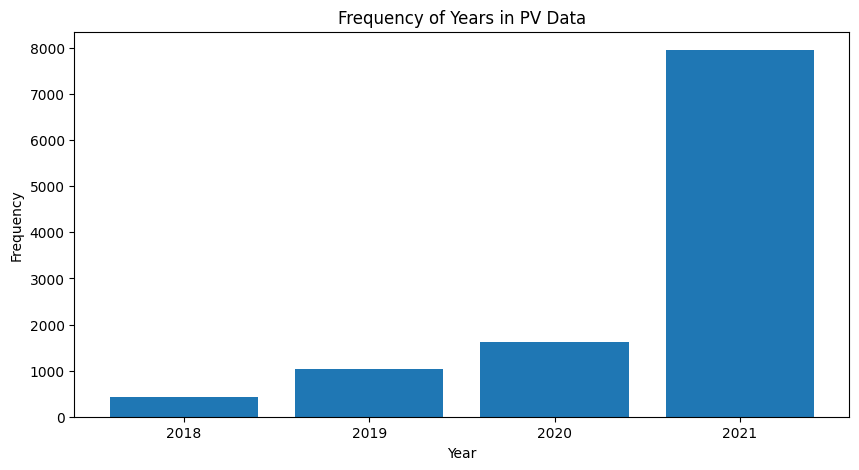

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have a DataFrame named df
# Extract the year from the 'pv_datetime' column
pv_df['year'] = pd.to_datetime(pv_df['pv_datetime']).dt.year

# Count the occurrences of each year
year_counts = pv_df['year'].value_counts().sort_index()

# Plot the frequency of the years
plt.figure(figsize=(10, 5))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Years in PV Data')
plt.xticks(year_counts.index)  # Ensure all years are shown on the x-axis
plt.show()



In [10]:
pv_df.columns

Index(['ss_id', 'pv_datetime', 'generation', 'hour'], dtype='object')

In [11]:
nan_percentage = pv_df.groupby('ss_id')['generation'].apply(lambda x: x.isna().mean() * 100).reset_index()
nan_percentage.columns = ['ss_id', 'nan_percentage']

# Filter ss_id where NaN percentage is greater than 80%
high_nan_ss_ids = nan_percentage[nan_percentage['nan_percentage'] > 80]

print("ss_id with more than 80% NaN values in generation:")
print(high_nan_ss_ids)

ss_id with more than 80% NaN values in generation:
Empty DataFrame
Columns: [ss_id, nan_percentage]
Index: []


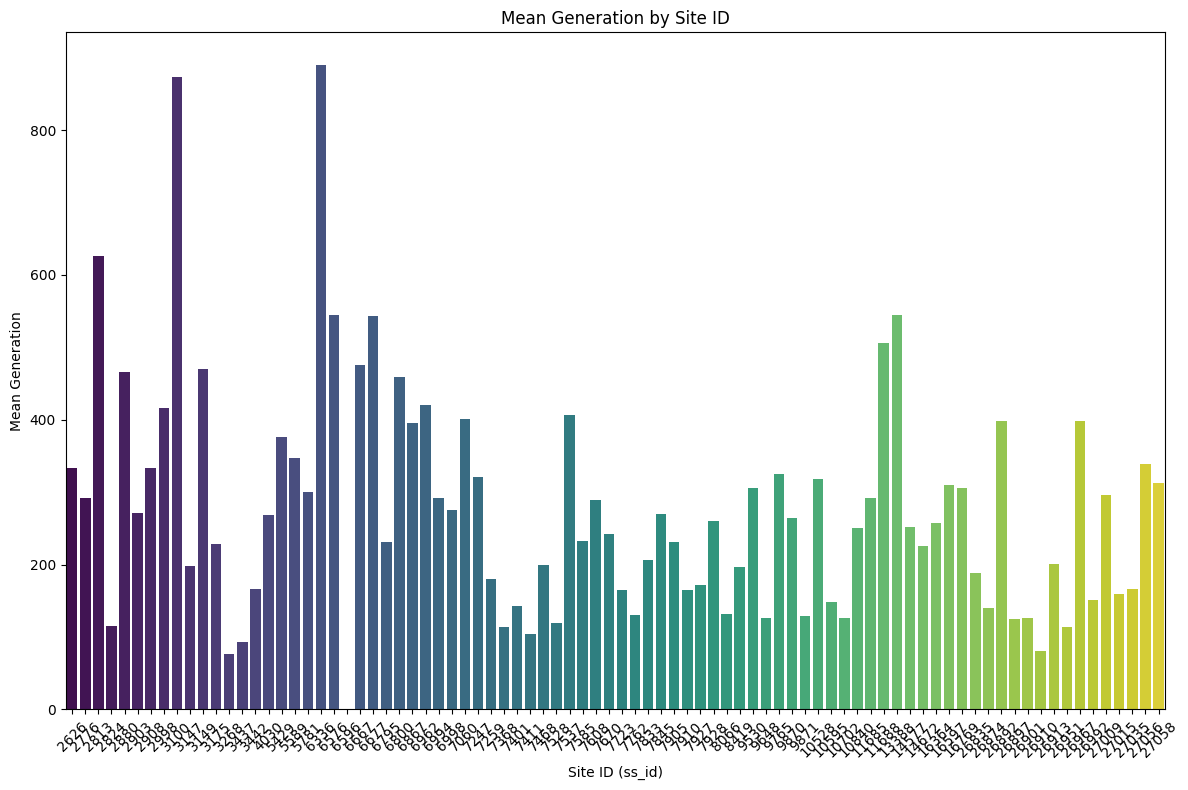

In [17]:
generation_mean = pv_df.groupby('ss_id')['generation'].mean().reset_index()
generation_mean.columns = ['ss_id', 'mean_generation']

# Plotting the data
plt.figure(figsize=(12, 8))
sns.barplot(x='ss_id', y='mean_generation', data=generation_mean, palette='viridis')

plt.xlabel('Site ID (ss_id)')
plt.ylabel('Mean Generation')
plt.title('Mean Generation by Site ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
pv_sites_id = [int(id) for id in pv_sites_id]  
# pv_sites_id

In [20]:
pv_site_dict = {'ss_id':[], "lat":[], "long": [], 'tilt':[], 'orientation':[]}

for id in pv_sites_id:
    row = meta_data[meta_data['ss_id'] == id]
    if not row.empty:
        pv_site_dict['ss_id'].append(id)
        pv_site_dict['lat'].append(row['latitude_rounded'].values[0])
        pv_site_dict['long'].append(row['longitude_rounded'].values[0])
        pv_site_dict['tilt'].append(row['tilt'].values[0])
        pv_site_dict['orientation'].append(row['orientation'].values[0])
    else:
        print('row empty')
        


print(pv_site_dict)
meta_site_df = pd.DataFrame.from_dict(pv_site_dict)
# meta_site_df

{'ss_id': [7910, 26926, 4030, 5589, 9871, 27058, 5781, 27056, 7259, 9765, 7411, 26992, 2908, 7537, 26892, 26874, 7603, 7833, 7905, 6492, 5429, 26910, 6839, 3280, 6596, 8066, 3175, 27038, 11688, 9530, 6994, 14672, 26901, 16364, 7845, 27009, 7928, 27015, 16597, 7762, 6952, 9870, 7247, 2824, 10168, 6667, 7670, 26866, 6800, 6998, 2626, 10595, 14666, 26897, 6867, 6677, 9648, 6962, 3437, 11685, 6576, 13388, 26835, 10206, 26951, 26967, 7401, 7117, 10586, 2813, 8419, 2628, 10528, 2903, 26913, 7608, 2998, 7468, 27035, 7585, 2880, 16769, 7723, 7927, 7060, 6336, 3268, 3865, 3149, 10840, 10702, 3147, 2776, 7528, 11401, 7368, 3100, 6795, 3442, 14577], 'lat': [50.54, 51.11, 55.8, 53.04, 53.42, 52.28, 55.8, 50.86, 51.43, 54.96, 51.94, 50.38, 50.25, 50.61, 51.57, 51.32, 51.87, 54.88, 54.08, 52.02, 51.67, 53.41, 55.46, 52.61, 54.53, 53.41, 55.54, 52.94, 55.77, 53.76, 51.31, 54.88, 53.51, 53.88, 54.91, 51.64, 51.15, 50.43, 55.83, 55.82, 51.56, 52.55, 53.02, 50.76, 53.29, 57.33, 54.57, 51.23, 53.14, 52.5

In [21]:
combined_df = pd.merge(pv_df, meta_site_df, on='ss_id', how='inner')
combined_df

,ss_id,pv_datetime,generation,hour,lat,long,tilt,orientation
0,7910,2021-10-01 02:00:00,0.0,1,50.54,-3.62,40.0,130.0
1,7910,2021-10-01 03:00:00,0.0,2,50.54,-3.62,40.0,130.0
2,7910,2021-10-01 04:00:00,0.0,3,50.54,-3.62,40.0,130.0
3,7910,2021-10-01 05:00:00,0.0,4,50.54,-3.62,40.0,130.0
4,7910,2021-10-01 06:00:00,0.0,5,50.54,-3.62,40.0,130.0
...,...,...,...,...,...,...,...,...
11947,14577,2021-10-24 19:00:00,0.0,32,51.61,-2.97,29.0,167.0
11948,14577,2021-10-24 20:00:00,0.0,33,51.61,-2.97,29.0,167.0
11949,14577,2021-10-24 21:00:00,0.0,34,51.61,-2.97,29.0,167.0
11950,14577,2021-10-24 22:00:00,0.0,35,51.61,-2.97,29.0,167.0


In [18]:
# combined_df.to_csv("test.csv")

In [69]:
# test = pd.read_csv("test.csv")
# test.head()

In [22]:
combined_df['pv_datetime'] = pd.to_datetime(combined_df['pv_datetime'])

# Extract date and hour from pv_datetime
combined_df['pv_date'] = combined_df['pv_datetime'].dt.date
combined_df['pv_hour'] = combined_df['pv_datetime'].dt.hour
combined_df

,ss_id,pv_datetime,generation,hour,lat,long,tilt,orientation,pv_date,pv_hour
0,7910,2021-10-01 02:00:00,0.0,1,50.54,-3.62,40.0,130.0,2021-10-01,2
1,7910,2021-10-01 03:00:00,0.0,2,50.54,-3.62,40.0,130.0,2021-10-01,3
2,7910,2021-10-01 04:00:00,0.0,3,50.54,-3.62,40.0,130.0,2021-10-01,4
3,7910,2021-10-01 05:00:00,0.0,4,50.54,-3.62,40.0,130.0,2021-10-01,5
4,7910,2021-10-01 06:00:00,0.0,5,50.54,-3.62,40.0,130.0,2021-10-01,6
...,...,...,...,...,...,...,...,...,...,...
11947,14577,2021-10-24 19:00:00,0.0,32,51.61,-2.97,29.0,167.0,2021-10-24,19
11948,14577,2021-10-24 20:00:00,0.0,33,51.61,-2.97,29.0,167.0,2021-10-24,20
11949,14577,2021-10-24 21:00:00,0.0,34,51.61,-2.97,29.0,167.0,2021-10-24,21
11950,14577,2021-10-24 22:00:00,0.0,35,51.61,-2.97,29.0,167.0,2021-10-24,22


## Matching pv data with NWP
Need to match pv_datetime, with nwp, split pv_datetime to date and time seperatly, match pv_date with nwp init_time, and pv_hour with nwp steps. 

- 12 is midnight, so need to match with previous time.  using `backfill`

In [33]:
# dataframes = []
combined_df.shape

(11952, 10)

In [36]:
# # approach is to match exact date and time with init_time, previous one,a nd then get all the next 48 steps from nwp data. 
# # take from pv_datetime, date and hour to match with nwp_init time, now go to next 48 rows in combined_dataset for the next 48 steps of pv_datetime
# # now match these 48 steps with 49 steps available in nwp data fro each init_time. 
# # and get the valeus of aviables for the next 48 steps and append to combine dataset. 

# # now conider that not all points have 48 hours continous data. so blocks can not be of 48 hours. 
def is_continuous(block):
    return all(block['pv_datetime'].diff().dropna() == pd.Timedelta(hours=1))

dataframes = []

# Iterate over the combined_df in steps of 36 to process each 36-hour block
for start_idx in range(0, len(combined_df), 36):
    block = combined_df.iloc[start_idx:start_idx + 36]
    if len(block) < 36 or not is_continuous(block):
        print("Not a continuous 36-hour block:", block.iloc[0]['pv_datetime'])
        continue  

    # print(block)

    ss_id = block.iloc[0]['ss_id']
    init_time = block.iloc[0]['pv_datetime']
    lat = block.iloc[0]['lat']
    lon = block.iloc[0]['long']
    hour = block.iloc[0]['hour']
    generation_values = block['generation'].values
    pv_datetimes = block['pv_datetime'].values
    tilt = block.iloc[0]['tilt']
    orientation = block.iloc[0]['orientation']

    # Match pv_datetime to the nearest previous init_time
    init_time_sel = nwp_data.sel(init_time=init_time, method="backfill")
    # print("init time", init_time_sel)
    
    # Retrieve the 36 steps of forecast data starting from the matched init_time
    data_sel = init_time_sel.sel(step=slice(pd.Timedelta(hours=0), pd.Timedelta(hours=35)))
    data_sel = data_sel.sel(latitude=lat, method="nearest") \
                       .sel(longitude=lon, method="nearest")
    
    # print("Data sel", data_sel)
    
    # Convert to DataFrame and pivot
    data_df = data_sel.to_dataframe().reset_index()
    pivot_df = data_df.pivot_table(index=['init_time', 'step'], columns='variable', values='ECMWF_UK').reset_index()

    # print("pivot", pivot_df)

    # Ensure pivot_df has 36 rows, filling with NaN if necessary
    if len(pivot_df) < 36:
        missing_rows = 36 - len(pivot_df)
        pivot_df = pd.concat([pivot_df, pd.DataFrame([{}] * missing_rows)], ignore_index=True)
    
    # Add the combined dataset columns
    for i in range(36):
        step_value = pivot_df.loc[i, 'step'] if i < len(pivot_df) else pd.NaT
        pv_datetime = pv_datetimes[i] if i < len(pv_datetimes) else pd.NaT
        pv_hour = block.iloc[i]['pv_hour'] if i < len(block) else 'NaN'
        hour = block.iloc[i]['hour'] if i < len(block) else 'NaN'
        
        # print(f"ss_id: {ss_id}, init_time: {init_time}, pv_datetime: {pv_datetime}, pv_hour: {pv_hour}, step: {step_value}, hour: {hour}")
        
        pivot_df.loc[i, 'ss_id'] = ss_id
        pivot_df.loc[i, 'pv_datetime'] = pv_datetimes[i] if i < len(pv_datetimes) else pd.NaT
        pivot_df.loc[i, 'generation'] = generation_values[i] if i < len(generation_values) else np.nan
        pivot_df.loc[i, 'pv_hour'] = block.iloc[i]['pv_hour'] if i < len(block) else np.nan
        pivot_df.loc[i, 'tilt'] = tilt
        pivot_df.loc[i, 'orientation'] = orientation
        pivot_df.loc[i, 'lat'] = lat
        pivot_df.loc[i, 'long'] = lon
        pivot_df.loc[i, 'hour'] = hour

    
    dataframes.append(pivot_df)



# # Iterate over the combined_df in steps of 48 to process each 48-hour block
# for start_idx in range(0, len(combined_df), 48):
#     block = combined_df.iloc[start_idx:start_idx + 48]
#     if len(block) < 48 or not is_continuous(block):
#         print("Not a continuous 48-hour block:", block.iloc[0]['pv_datetime'])
#         continue   # Skip blocks that are not full 48-hour periods

#     ss_id = block.iloc[0]['ss_id']
#     init_time = block.iloc[0]['pv_datetime']
#     lat = block.iloc[0]['lat']
#     lon = block.iloc[0]['long']
#     generation_values = block['generation'].values
#     pv_datetimes = block['pv_datetime'].values
#     tilt = block.iloc[0]['tilt']
#     orientation = block.iloc[0]['orientation']

#     # Match pv_datetime to the nearest previous init_time
#     init_time_sel = nwp_data.sel(init_time=init_time, method="backfill")
    
#     # Retrieve the 48 steps of forecast data starting from the matched init_time
#     data_sel = init_time_sel.sel(step=slice(pd.Timedelta(hours=0), pd.Timedelta(hours=47)))
#     data_sel = data_sel.sel(latitude=lat, method="nearest") \
#                        .sel(longitude=lon, method="nearest")
    
#     # Convert to DataFrame and pivot
#     data_df = data_sel.to_dataframe().reset_index()
#     pivot_df = data_df.pivot_table(index=['init_time', 'step'], columns='variable', values='ECMWF_UK').reset_index()

#     # Add the combined dataset columns
#     for i in range(48):
#         pivot_df.loc[i, 'ss_id'] = ss_id
#         pivot_df.loc[i, 'pv_datetime'] = pv_datetimes[i]
#         pivot_df.loc[i, 'generation'] = generation_values[i]

#     dataframes.append(pivot_df)
    



In [37]:
len(dataframes)

332

In [ ]:
# print(len(dataframes))
# # Combine all dataframes into one
# forecast_df = pd.concat(dataframes, ignore_index=True)

# # Display the final DataFrame
# print(forecast_df)

In [28]:
# # approach is to match exact date of pvdate with init time date, adn then match exact time of pv hour with step hour. 

# dataframes = []

# for index, row in combined_df.iterrows():

#     ss_id = row['ss_id']

#     # Match pv_date to init_time
#     init_time_sel = nwp_data.sel(init_time=row['pv_datetime'], method="backfill")
    
#     # Match pv_hour to step
#     step_sel = init_time_sel.sel(step=pd.Timedelta(hours=row['pv_hour']), method="nearest")
    
#     data_sel = step_sel.sel(latitude=row['lat'], method="nearest") \
#                        .sel(longitude=row['long'], method="nearest")
    

#     data_df = data_sel.to_dataframe().reset_index()
#     pivot_df = data_df.pivot_table(index=['init_time', 'step'], columns='variable', values='ECMWF_UK').reset_index()

#     pivot_df['ss_id'] = ss_id
#     pivot_df['pv_datetime'] = row['pv_datetime']
#     pivot_df['generation'] = row['generation']
#     pivot_df['pv_hour'] = row['pv_hour']
#     pivot_df['tilt'] = row['tilt']
#     pivot_df['orientation'] = row['orientation']
#     pivot_df['lat'] = row['lat']
#     pivot_df['long'] = row['long']
#     pivot_df['hour'] = row['hour']
    

#     dataframes.append(pivot_df)

In [38]:
# dataframes
print(len(dataframes))

332


In [40]:
final_df = pd.concat(dataframes, ignore_index=True)
desired_order = ['ss_id', 'init_time', 'step', 'generation', 'pv_datetime', 'pv_hour', 'hour', 'lat', 'long', 'tilt', 'orientation', 'dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10', 'v100']
final_df = final_df[desired_order]
print(final_df.shape)
print(final_df.columns)

(11952, 25)
Index(['ss_id', 'init_time', 'step', 'generation', 'pv_datetime', 'pv_hour',
       'hour', 'lat', 'long', 'tilt', 'orientation', 'dlwrf', 'dswrf', 'duvrs',
       'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10',
       'v100'],
      dtype='object', name='variable')


In [41]:
final_df

variable,ss_id,init_time,step,generation,pv_datetime,pv_hour,hour,lat,long,tilt,...,lcc,mcc,sde,sr,t2m,tcc,u10,u100,v10,v100
0,7910.0,2021-10-01 12:00:00,0 days 00:00:00,0.0,2021-10-01 02:00:00,2.0,1.0,50.54,-3.62,40.0,...,0.081787,0.032196,0.0,0.0,288.031982,0.093781,3.991792,5.481739,-2.940549,-3.940272
1,7910.0,2021-10-01 12:00:00,0 days 01:00:00,0.0,2021-10-01 03:00:00,3.0,2.0,50.54,-3.62,40.0,...,0.068420,0.002716,0.0,2874176.0,288.588867,0.069186,4.463814,6.045009,-2.550181,-3.385926
2,7910.0,2021-10-01 12:00:00,0 days 02:00:00,0.0,2021-10-01 04:00:00,4.0,3.0,50.54,-3.62,40.0,...,0.042419,0.082703,0.0,5882880.0,288.407715,0.099243,4.783910,6.504312,-2.375977,-3.192120
3,7910.0,2021-10-01 12:00:00,0 days 03:00:00,0.0,2021-10-01 05:00:00,5.0,4.0,50.54,-3.62,40.0,...,0.000610,0.006958,0.0,8620288.0,288.082031,0.007294,4.366065,5.940393,-1.291842,-1.790048
4,7910.0,2021-10-01 12:00:00,0 days 04:00:00,0.0,2021-10-01 06:00:00,6.0,5.0,50.54,-3.62,40.0,...,0.010437,0.011353,0.0,11098624.0,287.561035,0.014740,4.177423,5.885444,-0.610147,-0.925997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,14577.0,2021-10-23 12:00:00,1 days 07:00:00,0.0,2021-10-24 19:00:00,19.0,32.0,51.61,-2.97,29.0,...,0.303772,0.262238,0.0,4268692.5,285.503174,0.441193,2.875631,5.894978,2.656602,4.564731
11948,14577.0,2021-10-23 12:00:00,1 days 08:00:00,0.0,2021-10-24 20:00:00,20.0,33.0,51.61,-2.97,29.0,...,0.998291,0.239502,0.0,4268692.5,285.004395,0.998444,2.836988,5.659196,2.437841,4.005493
11949,14577.0,2021-10-23 12:00:00,1 days 09:00:00,0.0,2021-10-24 21:00:00,21.0,34.0,51.61,-2.97,29.0,...,0.759644,0.134430,0.0,4268692.5,285.472168,0.788849,3.325137,5.935806,3.054502,4.634418
11950,14577.0,2021-10-23 12:00:00,1 days 10:00:00,0.0,2021-10-24 22:00:00,22.0,35.0,51.61,-2.97,29.0,...,0.330414,0.043976,0.0,4268692.5,285.245117,0.358063,2.966614,5.370347,3.443857,5.454003


In [42]:
final_df.columns

Index(['ss_id', 'init_time', 'step', 'generation', 'pv_datetime', 'pv_hour',
       'hour', 'lat', 'long', 'tilt', 'orientation', 'dlwrf', 'dswrf', 'duvrs',
       'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10',
       'v100'],
      dtype='object', name='variable')

In [43]:
final_df.to_csv("result_data/data_tft_36.csv")

In [ ]:
## plots of generation and weather variables to see the trends
## add titl and orientation in dataset